In [24]:
import os
os.chdir('..')

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import webbrowser
from sklearn.utils import shuffle
from IPython.display import IFrame

from constants import plots3d_path
from data_analysis_utils.utils import define_features_var_grouping, check_features_distribution
from data_analysis_utils.proteins_similarity import pairwise_dist, aggregate_metrics_dim, aggregate_metrics_all, get_samples_low_high_pos_dist, compare_pdb_pairwise_dist
from data_analysis_utils.visualization import apply_mds, compare_pdb_plots
from data_analysis_utils.tda_utils import interesting_homology_filter, get_similar_protein_pairs

### Load data 

In [4]:
# Load encoded data with enzyme type and pdb_id
df = pd.read_csv('output/tda_encoded_proteins_assembly.csv')
df = shuffle(df, random_state=17).reset_index(drop=True)
df.shape

(14183, 84)

### Data analysis 

In [6]:
df.head()

,end_dim0_4,end_dim0_3,end_dim0_2,end_dim0_1,end_dim0_0,begin0_dim1,end0_dim1,a00_dim1,a10_dim1,b10_dim1,...,b12_dim2,a22_dim2,b22_dim2,a32_dim2,b32_dim2,a42_dim2,b42_dim2,a52_dim2,b52_dim2,pdb_id
0,0.016653,0.016829,0.017497,0.018127,0.020563,0.008818,2.287163,0.397747,0.008854,0.212187,...,-0.001136,-0.015003,0.015701,0.013206,-0.006437,-0.023021,-0.014598,-0.011707,0.013695,5N60
1,0.013948,0.018293,0.018507,0.019814,0.020948,0.015655,0.322974,0.116917,-0.042125,0.051454,...,-0.003463,-0.003617,-0.012425,-0.003859,0.003016,0.001733,-0.000613,-0.001436,-0.000055,1OED
2,0.028250,0.028999,0.029191,0.029231,0.033350,0.005733,0.924789,0.010331,0.006648,0.005211,...,0.007018,-0.000143,-0.006174,0.001364,0.001377,-0.002091,-0.000105,0.001839,0.001000,4AC7
3,0.017916,0.018095,0.018544,0.018621,0.991182,0.514619,3.548179,1.570846,-0.679233,-0.455567,...,-0.000155,-0.020321,0.010022,0.014369,-0.002203,-0.001113,-0.011260,-0.001214,0.006310,6QV0
4,0.043156,0.055253,0.056881,0.101645,0.138809,0.068090,2.583287,0.718226,-0.116782,0.383141,...,0.001824,0.002775,0.002837,0.001003,0.003037,-0.000466,0.002592,-0.001430,0.002117,4UJ3


In [7]:
df.describe()

,end_dim0_4,end_dim0_3,end_dim0_2,end_dim0_1,end_dim0_0,begin0_dim1,end0_dim1,a00_dim1,a10_dim1,b10_dim1,...,a12_dim2,b12_dim2,a22_dim2,b22_dim2,a32_dim2,b32_dim2,a42_dim2,b42_dim2,a52_dim2,b52_dim2
count,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,...,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000
mean,0.025872,0.027426,0.029586,0.033930,0.243241,0.024021,1.114969,0.213613,-0.050447,0.025080,...,-0.010251,-0.005071,-0.006930,0.000466,-0.001685,-0.000217,-0.000931,-0.000278,-0.000938,-0.000216
std,0.022489,0.029001,0.035468,0.055595,19.818749,0.278046,1.982165,0.488506,0.187288,0.086309,...,0.033438,0.062500,0.023607,0.015265,0.008634,0.007693,0.005828,0.004995,0.004821,0.004034
min,0.005795,0.005803,0.005890,0.006370,0.008128,0.000000,0.000000,0.000000,-4.586813,-1.995163,...,-0.960102,-0.989815,-0.533003,-0.412811,-0.287266,-0.171036,-0.195719,-0.081239,-0.095696,-0.056386
25%,0.016128,0.016876,0.017779,0.018953,0.021449,0.006098,0.332463,0.038857,-0.046097,0.005025,...,-0.013284,0.000025,-0.006712,-0.004373,-0.003039,-0.002594,-0.001746,-0.001580,-0.001375,-0.001071
50%,0.024674,0.025382,0.026381,0.027948,0.030874,0.008591,0.599700,0.082951,-0.003535,0.017955,...,-0.008626,0.006325,-0.002675,-0.000637,-0.000666,-0.000423,-0.000296,-0.000080,-0.000236,0.000002
75%,0.030841,0.032073,0.033780,0.036581,0.043545,0.016001,1.268246,0.174841,0.012175,0.042971,...,-0.000931,0.010352,0.001060,0.002848,0.001157,0.001445,0.000914,0.001094,0.000635,0.000936
max,1.037337,1.774901,2.283025,3.072257,2358.293495,20.255440,61.542136,12.075035,0.728428,2.014654,...,0.295423,0.194277,0.140664,0.212047,0.103101,0.142805,0.073979,0.143995,0.094906,0.088954


In [8]:
grouped_feat_var = define_features_var_grouping(df)
feat_cols = grouped_feat_var['feat_cols']
feat_cols_dim0 = grouped_feat_var['feat_cols_dim0']
feat_cols_begin_end = grouped_feat_var['feat_cols_begin_end']
features_var_dict_dim_land_shape_extrema = grouped_feat_var['features_var_dict_dim_land_shape_extrema']
features_var_dict_dim_land = grouped_feat_var['features_var_dict_dim_land']
features_var_dict_dim = grouped_feat_var['features_var_dict_dim']

dim0


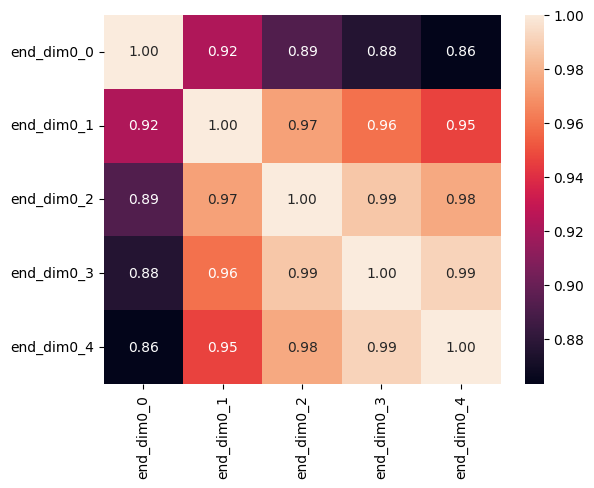

dim1_land1


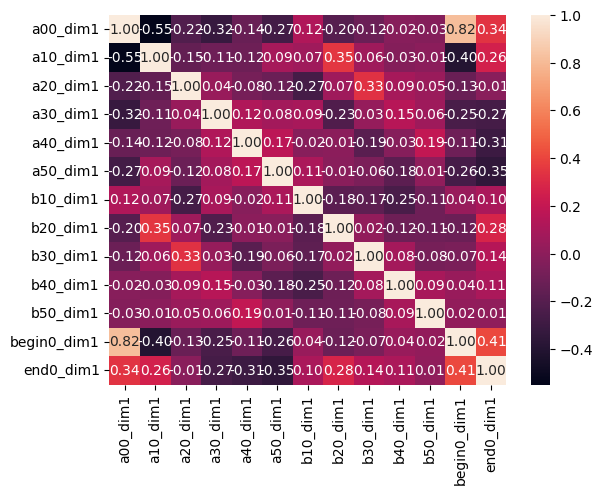

dim1_land2


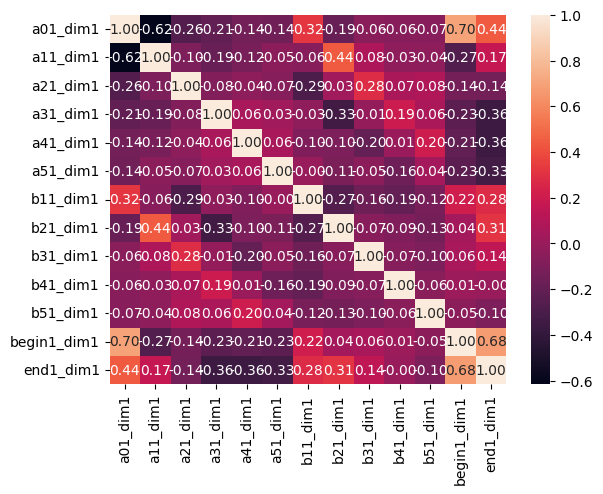

dim1_land3


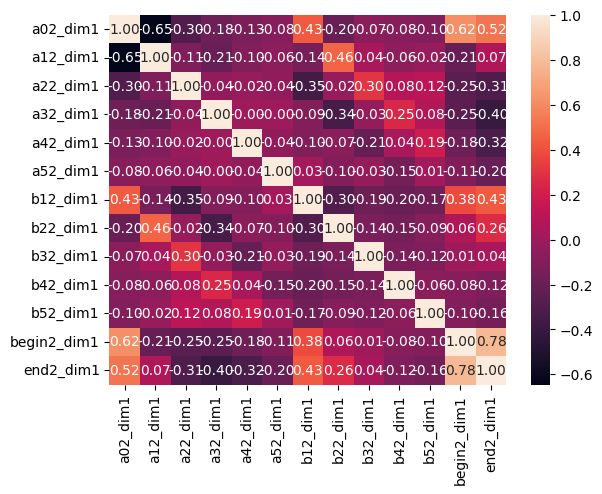

dim2_land1


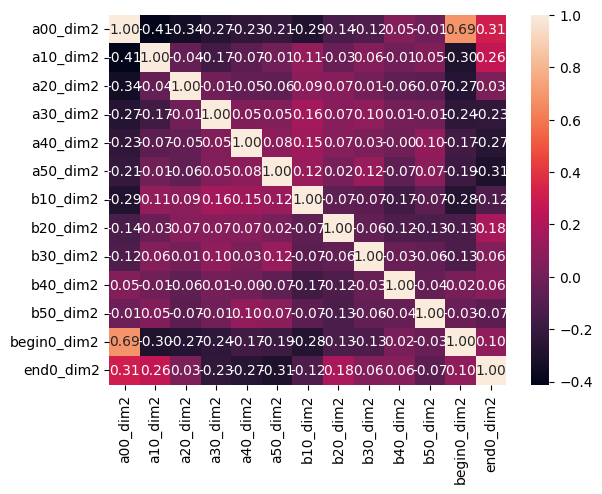

dim2_land2


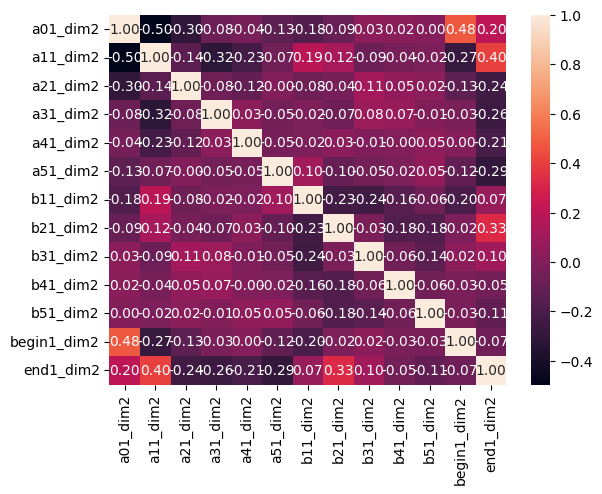

dim2_land3


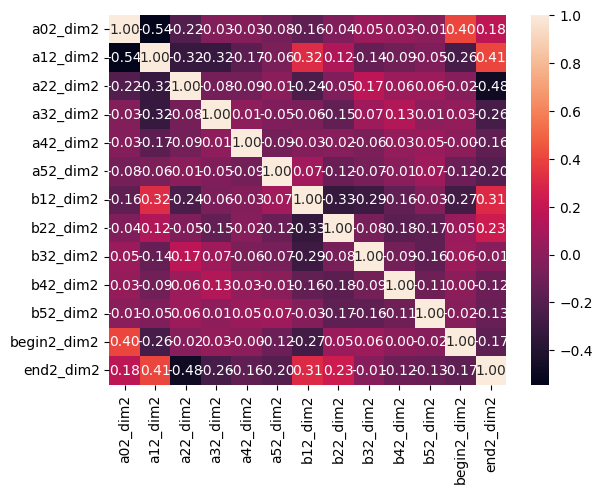

In [46]:
# Check correlation among group of features
for key in features_var_dict_dim_land.keys():
    df_corr = df[np.sort(features_var_dict_dim_land[key])].corr('spearman')
    sns.heatmap(df_corr, annot = True, fmt = '.2f')
    print(key)
    plt.show()

In [10]:
# Considerations:
# - dim 0 features are very correlated, what about taking only 0, 2 and 4?
# - begin_dim1 and end_dim1 are correlated, while Fourier coefficients are not (makes sense)
# - a10 is bigger than b10 for first landscape since for the approximated function we have f(0)=0 like sin, 
# - what if we take fewer Fourier coefficients? 3-series instead of 5?

In [11]:
# outlier_removal(df=x_train, cols_outliers_check=feat_cols_begin_end)

dim0


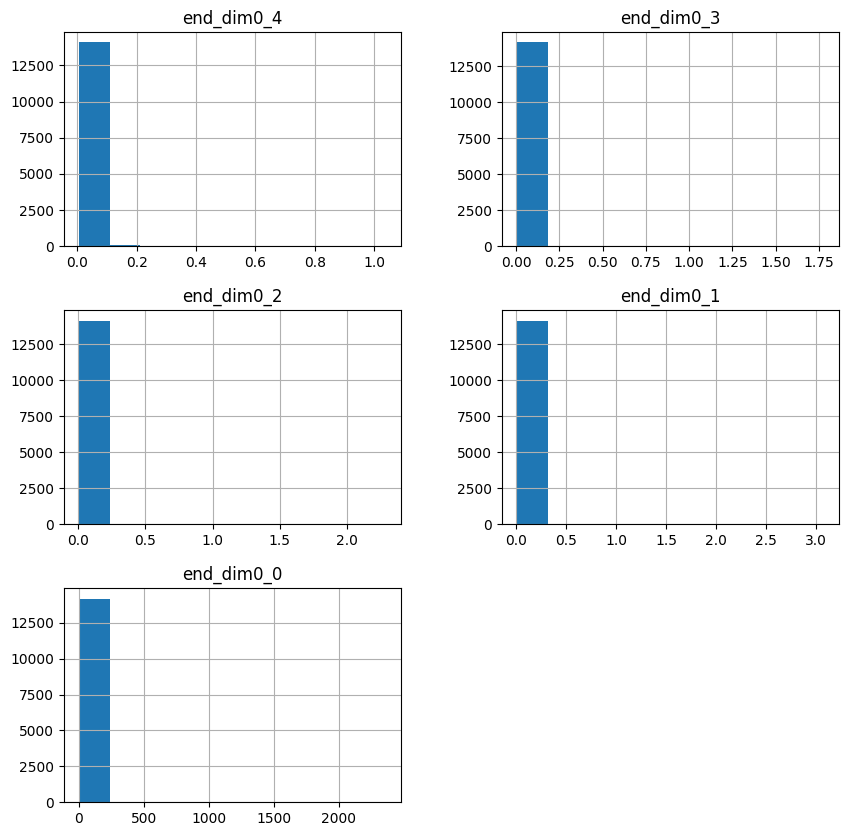

dim1_land1


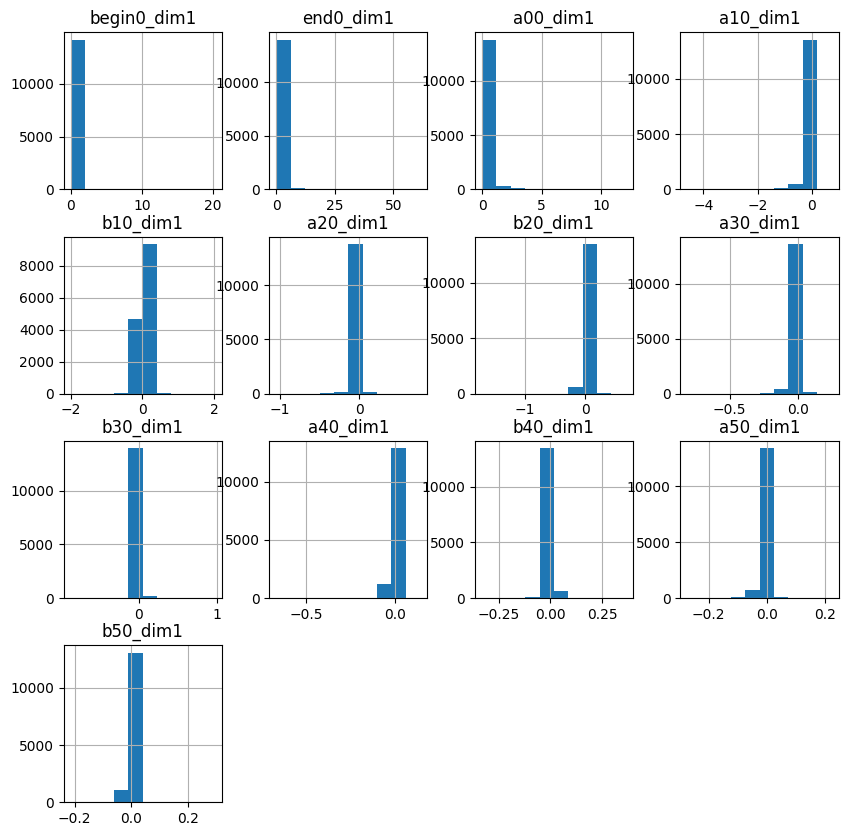

dim1_land2


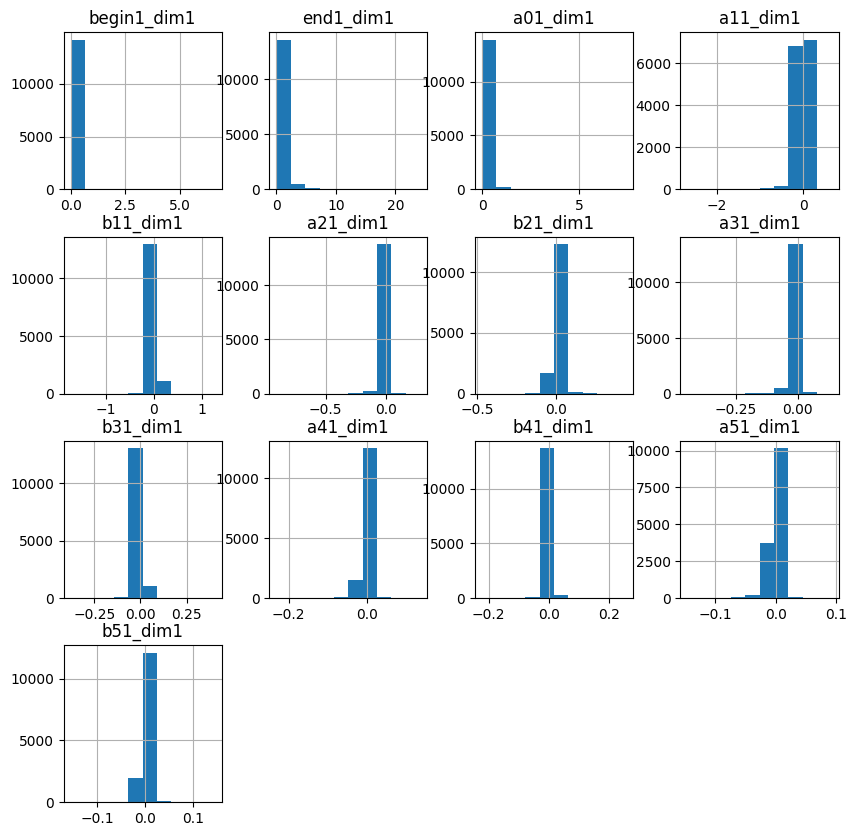

dim1_land3


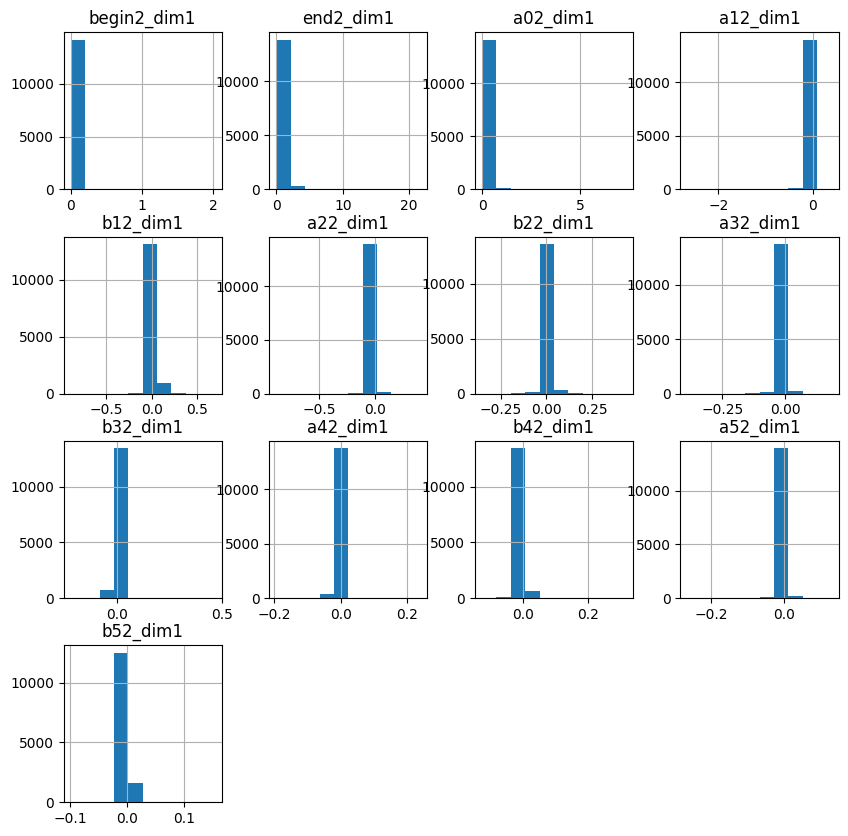

dim2_land1


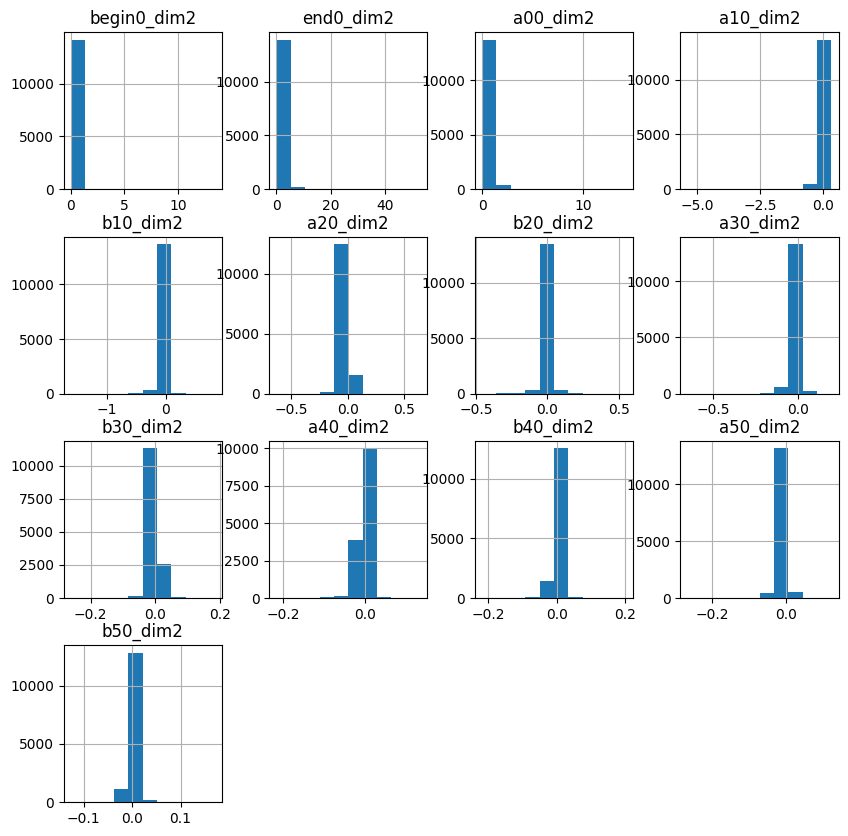

dim2_land2


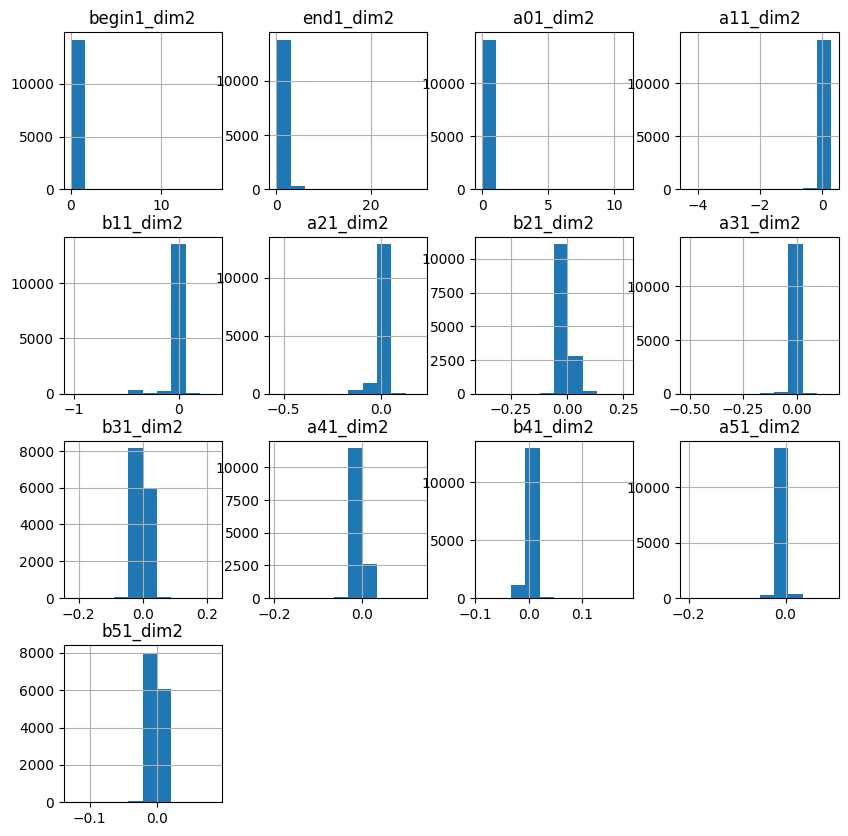

dim2_land3


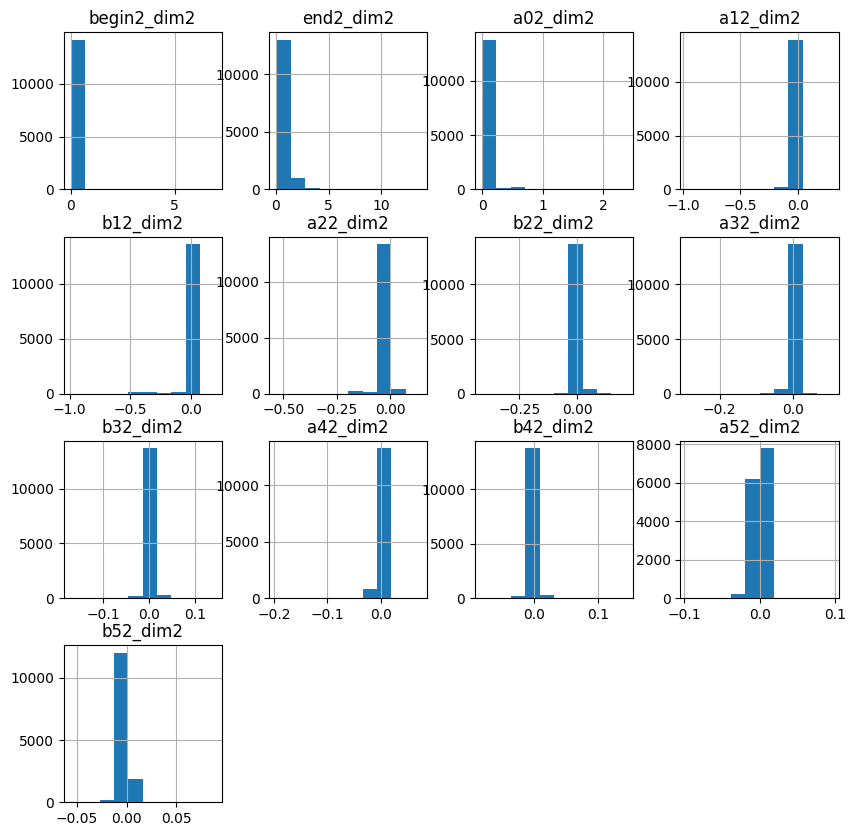

In [14]:
# Check features distribution
check_features_distribution(df, features_var_dict_dim_land)

In [15]:
# Check features distribution after removing outliers
# check_features_distribution(df, features_var_dict_dim_land)
# Now features distribution makes more sense

In [16]:
# let's look how extreme outliers look like
# todo: check 3d plot of outliers...

In [17]:
# Many proteins have trivial global shapes (contractible) so we can't conclude much from persistence homology.
# Let's look for proteins having one single connected component and non-trivial homology in dim 1 and 2.
# Anyway keep in mind all knots in 3d are homotopy equivalent, so we should not be able to tell the difference between different knotted chains.

In [18]:
df_fun_homology = interesting_homology_filter(df_tda_enc=df)

In [19]:
df_fun_homology

,end_dim0_4,end_dim0_3,end_dim0_2,end_dim0_1,end_dim0_0,begin0_dim1,end0_dim1,a00_dim1,a10_dim1,b10_dim1,...,a22_dim2,b22_dim2,a32_dim2,b32_dim2,a42_dim2,b42_dim2,a52_dim2,b52_dim2,pdb_id,connected
4,0.043156,0.055253,0.056881,0.101645,0.138809,0.068090,2.583287,0.718226,-0.116782,0.383141,...,0.002775,0.002837,0.001003,0.003037,-0.000466,0.002592,-0.001430,0.002117,4UJ3,True
17,0.016575,0.017673,0.018592,0.018820,0.020035,0.018784,3.509002,1.156327,-0.425705,-0.356137,...,-0.020925,0.011593,-0.021068,-0.020673,-0.004177,-0.011008,0.006125,0.011747,6W2D,True
18,0.016832,0.017065,0.017089,0.017954,0.018615,0.049944,2.273621,0.568371,-0.039392,-0.103016,...,-0.008349,0.005242,-0.004830,0.003525,-0.003430,-0.001756,-0.008311,-0.002748,6NB3,True
24,0.011878,0.011878,0.011878,0.011880,0.011881,0.084085,1.615964,1.257051,-0.456933,-0.001608,...,0.024088,0.027960,-0.016281,-0.022234,-0.003152,0.001856,-0.003742,-0.006012,7NJS,True
34,0.024718,0.025295,0.026758,0.034462,0.039918,0.060054,1.191812,0.773993,-0.322072,0.079469,...,-0.011132,-0.003006,0.002430,-0.004309,0.001180,0.000841,-0.000445,0.000383,3V4P,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14120,0.018805,0.020564,0.022521,0.022528,0.022707,0.053117,0.814717,0.614173,-0.225398,-0.010427,...,0.001699,0.005687,-0.002008,0.001864,-0.002839,-0.001066,-0.002857,-0.002488,7NEZ,True
14131,0.040902,0.040910,0.047551,0.060838,0.075519,0.006760,1.286164,0.027885,0.012086,0.015686,...,-0.115847,0.083258,0.002737,0.004041,0.005889,-0.015858,-0.026820,0.001427,6HW3,True
14161,0.016374,0.016382,0.017712,0.019447,0.020897,0.121563,2.039404,1.589428,-0.569677,-0.008609,...,0.002515,0.002575,0.001297,0.003027,0.000039,0.003009,-0.001016,0.002350,7MQR,True
14166,0.025913,0.025972,0.026379,0.028009,0.028691,0.034115,1.144141,0.501523,-0.217700,0.177874,...,-0.003317,0.016731,-0.009171,0.005574,-0.004156,-0.000724,-0.003243,-0.003442,7W2Y,True


#### Pairwise distance analysis

In [20]:
# Get pairwise distance at different aggregation levels
pair_dist_dict = pairwise_dist(df=df_fun_homology, dict_features_var_dims_lands=features_var_dict_dim_land_shape_extrema)
pair_dist_dict_dim = aggregate_metrics_dim(pair_dist_dict)
pair_dist_final = aggregate_metrics_all(pair_dist_dict_dim)

In [21]:
# are there better distances? check what happens at different dims...
#df_dim0_close_pairs = get_samples_low_high_pos_dist(pair_dist_dict_dim['dim0'], n=5, low=True).drop_duplicates().rename(columns={'distance':'distance0'})
#df_dim1_close_pairs = get_samples_low_high_pos_dist(pair_dist_dict_dim['dim1'], n=5, low=True).drop_duplicates().rename(columns={'distance':'distance1'})
#df_dim2_close_pairs = get_samples_low_high_pos_dist(pair_dist_dict_dim['dim2'], n=5, low=True).drop_duplicates().rename(columns={'distance':'distance2'})
#df_dim1_close_dim2_close = df_dim1_close_pairs.merge(df_dim2_close_pairs).sort_values(by='distance1',ascending=False).reset_index(drop=True)

In [98]:
df_sim_pairs = get_similar_protein_pairs(df_fun_homology, pair_dist_final, n=10)

In [112]:
df_sim_pairs.head(5)

,pdb_id1,pdb_id2,distance,area_dim1_land1_pdb1,area_dim2_land1_pdb1,area_dim1_land1_pdb2,area_dim2_land1_pdb2
0,4BOO,2BG9,0.000081,0.253681,0.474040,0.253691,0.474058
1,4BOI,2BG9,0.000098,0.253721,0.474019,0.253691,0.474058
2,2BG9,4BOT,0.000251,0.253691,0.474058,0.253707,0.474091
3,2BG9,4BOR,0.000266,0.253691,0.474058,0.253715,0.474049
4,2BG9,4BON,0.000335,0.253691,0.474058,0.253659,0.474064


In [100]:
# look for similar proteins but filter too similar ones
df_sim_pairs[df_sim_pairs['distance']>0.1]

,pdb_id1,pdb_id2,distance,area_dim1_land1_pdb1,area_dim2_land1_pdb1,area_dim1_land1_pdb2,area_dim2_land1_pdb2
830,5NIF,4Y8Q,0.100025,0.019521,1.777561,0.022161,1.860394
831,4QZ1,5CGH,0.100199,0.032703,1.806311,0.024163,1.889579
832,6OA9,7XKR,0.100321,0.089004,0.240214,0.195912,0.240925
833,7CZR,7KMK,0.100352,1.616179,0.053850,1.768168,0.039578
834,4Z1M,5ZGB,0.100410,0.101808,0.290475,0.108736,0.230296
...,...,...,...,...,...,...,...
10030,2CDH,4V1A,12.871107,8.792700,14.255517,3.176648,0.151931
10031,2CDH,5NZU,13.470740,8.792700,14.255517,1.151798,0.210288
10032,2CDH,3EPF,13.750318,8.792700,14.255517,0.734376,0.083603
10033,2CDH,8ADL,13.827830,8.792700,14.255517,2.708150,3.559602


In [113]:
# at first glance it seems proteins with distance <0.05 are the same 
pairs_high_sim = list(set(df_sim_pairs[df_sim_pairs['distance']<0.05]['pdb_id1']).union(set(df_sim_pairs[df_sim_pairs['distance']<0.05]['pdb_id2'])))

In [223]:
df_pairs_high_sim = pair_dist_final.loc[pairs_high_sim][pairs_high_sim]

In [224]:
df_pairs_high_sim

,4BOT,6ZOU,7NEZ,4BOR,4QWR,4QV3,4YA0,4QV6,8DD2,6HV3,...,7SMS,4Y9Y,5FGH,4Y8I,1VRQ,4BON,8BVQ,3TDD,3AD7,5CZ6
4BOT,0.000000,1.044766,0.286650,0.000143,1.050644,1.181991,1.071463,1.213935,0.190418,1.241579,...,0.262775,1.134972,1.049029,1.068380,0.536123,0.000567,0.255918,0.940583,0.525109,1.197201
6ZOU,1.044766,0.000000,1.004232,1.044774,0.179401,0.153623,0.111121,0.180704,1.010832,0.221447,...,0.875943,0.105630,0.120403,0.173693,0.745239,1.044718,1.194245,0.260882,0.749199,0.159832
7NEZ,0.286650,1.004232,0.000000,0.286660,1.026745,1.142440,1.048313,1.172562,0.276108,1.211438,...,0.259905,1.096614,1.021313,1.028263,0.490339,0.286868,0.321918,0.875657,0.472112,1.154986
4BOR,0.000143,1.044774,0.286660,0.000000,1.050652,1.181998,1.071471,1.213942,0.190435,1.241587,...,0.262787,1.134980,1.049037,1.068388,0.536143,0.000548,0.255919,0.940590,0.525129,1.197209
4QWR,1.050644,0.179401,1.026745,1.050652,0.000000,0.205457,0.112754,0.224606,1.018031,0.257064,...,0.882486,0.128058,0.117131,0.049770,0.759572,1.050585,1.216341,0.310667,0.763691,0.218031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4BON,0.000567,1.044718,0.286868,0.000548,1.050585,1.181937,1.071411,1.213883,0.190369,1.241529,...,0.262962,1.134918,1.048979,1.068325,0.536231,0.000000,0.255859,0.940541,0.525226,1.197151
8BVQ,0.255918,1.194245,0.321918,0.255919,1.216341,1.330943,1.221797,1.362169,0.305685,1.388246,...,0.432524,1.285060,1.196907,1.217166,0.636877,0.255859,0.000000,1.086858,0.615988,1.344947
3TDD,0.940583,0.260882,0.875657,0.940590,0.310667,0.382249,0.297413,0.415973,0.908020,0.453847,...,0.771896,0.341736,0.263348,0.317471,0.732131,0.940541,1.086858,0.000000,0.727745,0.393571
3AD7,0.525109,0.749199,0.472112,0.525129,0.763691,0.891293,0.783305,0.920309,0.392329,0.947001,...,0.305058,0.844609,0.756093,0.774788,0.041685,0.525226,0.615988,0.727745,0.000000,0.903067


In [211]:
df_sim_pairs[df_sim_pairs['distance']<0.05]

,pdb_id1,pdb_id2,distance,area_dim1_land1_pdb1,area_dim2_land1_pdb1,area_dim1_land1_pdb2,area_dim2_land1_pdb2
0,4BOO,2BG9,0.000081,0.253681,0.474040,0.253691,0.474058
1,4BOI,2BG9,0.000098,0.253721,0.474019,0.253691,0.474058
2,2BG9,4BOT,0.000251,0.253691,0.474058,0.253707,0.474091
3,2BG9,4BOR,0.000266,0.253691,0.474058,0.253715,0.474049
4,2BG9,4BON,0.000335,0.253691,0.474058,0.253659,0.474064
5,7KFB,7M8L,0.010665,0.349510,0.283718,0.361104,0.284265
6,3BDM,4JT0,0.026612,0.019725,1.748998,0.019826,1.765243
7,3BDM,4JSQ,0.027798,0.019725,1.748998,0.019222,1.747213
8,6HVS,4QV5,0.029631,0.019686,1.799041,0.022240,1.834070
9,4Y9Y,5BXL,0.034090,0.021994,1.827205,0.021884,1.864520


### Clustering 

In [174]:
def cluster_data(data, min_cluster_size=5):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    label = clusterer.fit_predict(data)
    df_clust = pd.DataFrame(label, index=data.index, columns=['label'])
    print("clusters size")
    print(df_clust.value_counts())
    df_clust_list = df_clust.reset_index().groupby('label').aggregate(lambda x: x.unique().tolist()).reset_index().rename(columns={'index':'pdb_ids'})
    return df_clust_list

In [215]:
df_cluster = cluster_data(df_pairs_high_sim[df_pairs_high_sim.index], min_cluster_size=5)

clusters size
label
 2       35
 0       21
 1       10
-1        3
dtype: int64


In [216]:
ex_label = 0

In [217]:
ex_cluster = list(df_cluster[df_cluster['label']==ex_label]['pdb_ids'])[0]

In [218]:
ex_cluster

['4BOT',
 '7NEZ',
 '4BOR',
 '8DD2',
 '2BG9',
 '7M8L',
 '7QL5',
 '6HCO',
 '6X3W',
 '2GAG',
 '4BOI',
 '7V5M',
 '7R1W',
 '3ADA',
 '4BOO',
 '7KFB',
 '7SMS',
 '1VRQ',
 '4BON',
 '8BVQ',
 '3AD7']

In [219]:
pdb_links_3d = [f"https://www.rcsb.org/3d-sequence/{pdb_id}?assemblyId=1" for pdb_id in ex_cluster]
pdb_links_structure = [f"https://www.rcsb.org/structure/{pdb_id}?assemblyId=1" for pdb_id in ex_cluster]

In [220]:
pdb_links_structure

['https://www.rcsb.org/structure/4BOT?assemblyId=1',
 'https://www.rcsb.org/structure/7NEZ?assemblyId=1',
 'https://www.rcsb.org/structure/4BOR?assemblyId=1',
 'https://www.rcsb.org/structure/8DD2?assemblyId=1',
 'https://www.rcsb.org/structure/2BG9?assemblyId=1',
 'https://www.rcsb.org/structure/7M8L?assemblyId=1',
 'https://www.rcsb.org/structure/7QL5?assemblyId=1',
 'https://www.rcsb.org/structure/6HCO?assemblyId=1',
 'https://www.rcsb.org/structure/6X3W?assemblyId=1',
 'https://www.rcsb.org/structure/2GAG?assemblyId=1',
 'https://www.rcsb.org/structure/4BOI?assemblyId=1',
 'https://www.rcsb.org/structure/7V5M?assemblyId=1',
 'https://www.rcsb.org/structure/7R1W?assemblyId=1',
 'https://www.rcsb.org/structure/3ADA?assemblyId=1',
 'https://www.rcsb.org/structure/4BOO?assemblyId=1',
 'https://www.rcsb.org/structure/7KFB?assemblyId=1',
 'https://www.rcsb.org/structure/7SMS?assemblyId=1',
 'https://www.rcsb.org/structure/1VRQ?assemblyId=1',
 'https://www.rcsb.org/structure/4BON?assembly

In [221]:
pdb_links_structure = pdb_links_structure[:8]

In [222]:
# open links to pdb website
for url in pdb_links_structure:
    webbrowser.open(url)

In [ ]:
stop

In [ ]:
# most common protein: yeast 20S
# others:
# alpha virsues
# spike protein covid + antibodies
#

In [ ]:
# dg.sort_values(by=['area_dim1_land3_pdb1','pdb_id1','distance'],ascending=[False,False,True])#.head(20)
# nice example:7CW2, 7CW3, 7CVZ, 6Z6O, 3J0F, 3J0C are similar viruses - Chikungunya,  Sindbis virion and Venezuelan Equine Encephalitis Virus


In [ ]:
df_small

In [ ]:
get_similar_protein_pairs(pair_dist_dict_dim['dim1'], n=5)

In [ ]:
i = 2728

In [ ]:
for i in range(2727,2730):
    sim_pair = list(df_similar_dist_diff_type.reset_index(drop=True)[['pdb_id1','pdb_id2']].loc[i].values)
    compare_pdb_pairwise_dist(pdb_id1=sim_pair[0], pdb_id2=sim_pair[1], dict_dist_no_aggr=pair_dist_dict, dict_dist_aggr_dim=pair_dist_dict_dim, dist_aggr_global=pair_dist_final)

In [ ]:
sim_pair = list(df_similar_dist_diff_type.reset_index(drop=True)[['pdb_id1','pdb_id2']].loc[i].values)

In [ ]:
j=6

In [ ]:
sim_pair = list(df_dim0_close_dim1_far[['pdb_id1','pdb_id2']].loc[j].values)

In [ ]:
sim_pair = ['4YMK','4EKZ']

In [ ]:
# 4TOB (big dim2 hole) and 2P0I (small dim2 hole)

In [ ]:
compare_pdb_pairwise_dist(pdb_id1=sim_pair[0], pdb_id2=sim_pair[1], dict_dist_no_aggr=pair_dist_dict, dict_dist_aggr_dim=pair_dist_dict_dim, dist_aggr_global=pair_dist_final)

In [ ]:
# 3d plots from pdb website are nicer and also seem a bit different..is it or is it just a matter of perspective?

In [ ]:
# nice examples: 4A9G (sphere), 7CM5 (torus), 

#### Data visualization 

In [ ]:
compare_pdb_plots(pdb_list=sim_pair)

In [ ]:
# look for examples with high dim1/2 difference and low dim0 diff
# what's persistence homology of a 3d knot?

In [ ]:
stop

In [ ]:
# Use Multi Dimensional Scaling on pairwise distances to visualize data in 3d
# This is done at different aggregation levels
# No aggregation
for k, v in zip(pair_dist_dict.keys(), pair_dist_dict.values()):
    apply_mds(title=k,df_dissim=v)

In [ ]:
# Aggregate at dim level
for k, v in zip(pair_dist_dict_dim.keys(), pair_dist_dict_dim.values()):
    apply_mds(title=k,df_dissim=v,labels=df_small['enzyme_type'],enzyme_color_dict=enzyme_ec_label_color_dict)
# Aggregate all dims and all lands
apply_mds(title='all dim',df_dissim= pair_dist_final,labels=df_small['enzyme_type'],enzyme_color_dict=enzyme_ec_label_color_dict)

In [ ]:
# todo: reduce size of created pngs

In [ ]:
# it seems hydrolases can have multiple 3dim holes while other enzymes usually do not

In [ ]:
stop